An implementation BertViz's head_view. With this tool it is possible to visualize the self-attention mechanism for BERT and RoBERTa. Furthermore, we have implemented LUKE's *entity-aware* self-attention. We also provide the model_view for the visualization. 

Note, we provide a sample dataset to play around with but you can easily generate your own samples. Simple follow the instruction on the Git page for further intructions.


BertViz repo: https://github.com/jessevig/bertviz //
LUKE repo: https://github.com/studio-ousia/luke

In [1]:
data_dir = "sample_data/output_attentions.p"

# Import Packages and define functions

In [2]:
from bertviz import head_view
from transformers import BertTokenizer, BertModel, RobertaModel, RobertaTokenizer
import pickle
from bertviz.util import drop_down, sentence_index, print_sentence, get_entity_string, format_special_chars, plot_attention_token2token

In [3]:
def show_head_view(model, tokenizer, sentence_a, sentence_b=None, layer=None, heads=None, format_attention=True):
    inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids']
    if sentence_b:
        token_type_ids = inputs['token_type_ids']
        attention = model(input_ids, token_type_ids=token_type_ids)[-1]
        sentence_b_start = token_type_ids[0].tolist().index(1)
    else:
        attention = model(input_ids)[-1]
        sentence_b_start = None
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)  
    return head_view(attention, tokens, sentence_b_start, layer=layer, heads=heads, format_data=format_attention)

# Load model and LUKE data

In [4]:
luke_data = pickle.load( open( f"{data_dir}", "rb" ))
sentences = [luke_data[sent]["sentence"] for sent in luke_data.keys()]

luke_data = get_entity_string(luke_data)
sentences_with_entity = [luke_data[sent]["sentence_with_entity"] for sent in luke_data]

# Head View
The attention-head view visualizes attention in one or more heads in a particular layer in the model.

## Usage
* **Hover** over any **token** on the left/right side of the visualization to filter attention from/to that token. The colors correspond to different attention heads.
* **Double-click** on any of the **colored tiles** at the top to filter to the corresponding attention head.
* **Single-click** on any of the **colored tiles** to toggle selection of the corresponding attention head. 
* **Click** on the **Layer** drop-down to change the model layer (zero-indexed).
* The lines show the attention from each token (left) to every other token (right). Darker lines indicate higher attention weights. When multiple heads are selected, the attention weights are overlaid on one another. 

### Run cell 👇🏼 and then simple use the dropdown to select the sentence of interest

In [5]:
sentence_select = drop_down(options=sentences_with_entity)
display(sentence_select)

Dropdown(description='Select:', options=('Beyonce lives in Los Angeles . [entity:Los Angeles]', 'Beyonce lives…

### (re-run below cell when updating the dropdown)

In [6]:
do_lower_case = True
output_attentions=True
model_version_bert = 'bert-base-uncased'
model_version_roberta = 'roberta-base'

sentence_a = sentence_select.value[:sentence_select.value.find("[")-1]
sentence_b = None

# BERT: 
model_version_bert = 'bert-base-uncased'
model_bert = BertModel.from_pretrained(model_version_bert, output_attentions=output_attentions)
tokenizer_bert = BertTokenizer.from_pretrained(model_version_bert, do_lower_case=do_lower_case)
# RoBERTa:
model_version_roberta = 'roberta-base'
model_roberta = RobertaModel.from_pretrained(model_version_roberta, output_attentions=output_attentions)
tokenizer_roberta = RobertaTokenizer.from_pretrained(model_version_roberta)
# LUKE
entity = sentence_select.value[sentence_select.value.find("[")+8:-1]
index = sentence_index(luke_data, sentence_a, entity)
attention_luke = luke_data[f"sent_{index}"]["attention"]
tokens_luke = luke_data[f"sent_{index}"]["tokens"]

# Tokens for other Token-2-Token plot:
tokens_in_sentence = format_special_chars(luke_data[f"sent_{index}"]["tokens"])

# Plot: 
print_sentence(sentence_a, sentence_b)
print(f"\n")
print(f"Model: {model_version_bert}")
show_head_view(model_bert, tokenizer_bert, sentence_a, sentence_b)
print(f"\n")
print(f"Model: {model_version_roberta}")
show_head_view(model_roberta, tokenizer_roberta, sentence_a, sentence_b)
print(f"\n")
print(f"Model: LUKE")
head_view(attention_luke, tokens_luke, format_data=False)

Sentence: The doctor asked the nurse a question . She


Model: bert-base-uncased


<IPython.core.display.Javascript object>



Model: roberta-base


<IPython.core.display.Javascript object>



Model: LUKE


<IPython.core.display.Javascript object>

# Look at Token-to-Token attention for LUKE throughout layers
### Use the dropdowns 👇🏼 to selecet Token_1 and Token_2 at see the average head attention (line, where each dot represents an attention head). 

##### Note, the implementation is meant for unique tokens (it is case sensitive, i.e. "The" and "the" are different). 

In [7]:
token1 = drop_down(options=tokens_in_sentence, description="Token 1 $\longrightarrow$")
token2 = drop_down(options=tokens_in_sentence, description="$\longrightarrow$ Token 2")
display(token1); display(token2)

Dropdown(description='Token 1 $\\longrightarrow$', options=('<s>', 'The', 'doctor', 'asked', 'the', 'nurse', '…

Dropdown(description='$\\longrightarrow$ Token 2', options=('<s>', 'The', 'doctor', 'asked', 'the', 'nurse', '…

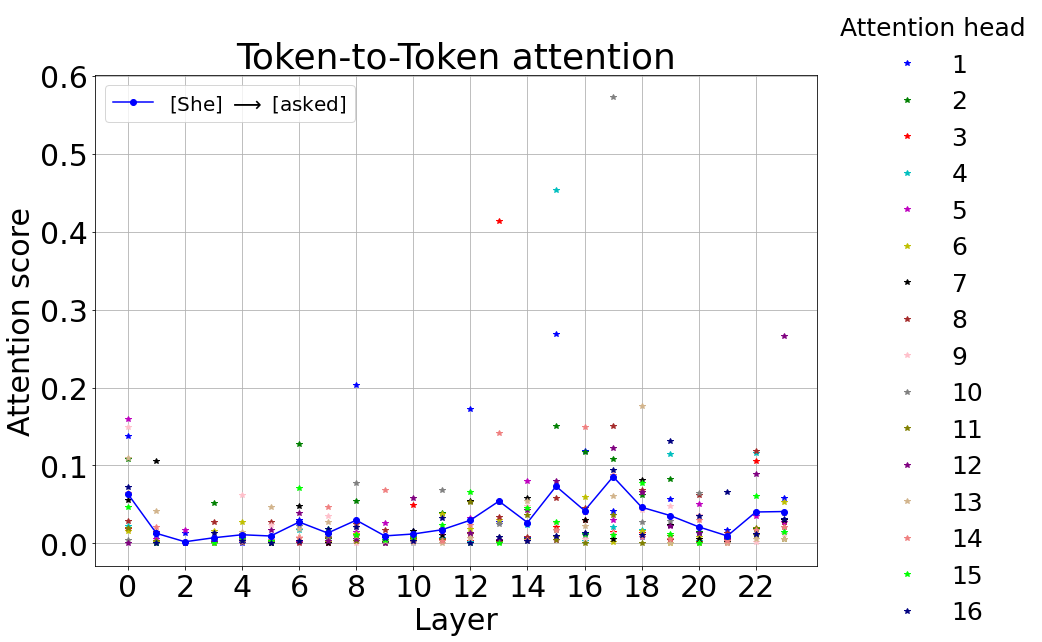

In [8]:
plot = plot_attention_token2token(tokens_in_sentence, attention_luke, token1.value, token2.value)